# DCGAN (MNIST)

- https://github.com/jacobgil/keras-dcgan/blob/master/dcgan.py

In [129]:
%matplotlib inline

In [135]:
from keras.models import Sequential
from keras.layers import Dense, Reshape
from keras.layers.core import Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

## モデル構築

In [131]:
def generator_model():
    layers = [
        Dense(1024, input_dim=100),
        Activation('tanh'),
        Dense(7 * 7 * 128),
        BatchNormalization(),
        Activation('tanh'),
        Reshape((7, 7, 128), input_shape=(7 * 7 * 128,)),
        UpSampling2D(size=(2, 2)),  # 14x14
        Conv2D(64, (5, 5), padding='same'),
        Activation('tanh'),
        UpSampling2D(size=(2, 2)),  # 28x28
        Conv2D(1, (5, 5), padding='same'),
        Activation('tanh')        
    ]
    model = Sequential(layers)
    return model

- 論文の学習を安定させる工夫（LeakyReLUなど）は無視して最低限のシンプルな構成
- UpSamplingで出力の特徴マップのサイズを拡大しながらMNISTの28x28に近づける
- Conv2Dでチャネル数（特徴マップ数）は減らしていき、最終的に1チャンネル（白黒）の画像にする

In [132]:
gen = generator_model()
gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 1024)              103424    
_________________________________________________________________
activation_275 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_142 (Dense)            (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_39 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_276 (Activation)  (None, 6272)              0         
_________________________________________________________________
reshape_39 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_74 (UpSampling (None, 14, 14, 128)       0         
__________

In [133]:
def discriminator_model():
    layers = [
        Conv2D(64, (5, 5), padding='same', input_shape=(28, 28, 1)),
        Activation('tanh'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (5, 5)),
        Activation('tanh'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(1024),
        Activation('tanh'),
        Dense(1),
        Activation('sigmoid')
    ]
    model = Sequential(layers)
    return model

- 通常のCNNと同じ構成
- MaxPoolingで特徴マップサイズを縮小
- チャンネル数は増やしていく

In [90]:
dis = discriminator_model()
dis.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 28, 28, 64)        1664      
_________________________________________________________________
activation_223 (Activation)  (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 10, 10, 128)       204928    
_________________________________________________________________
activation_224 (Activation)  (None, 10, 10, 128)       0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 3200)              0         
__________

In [25]:
def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

- Generatorは単独では学習できない
- Generatorが出力した画像をDiscriminatorが処理した結果を使って学習する
- そのため2つを連結したモデルが必要
- Generatorを学習させるときはdiscriminatorは学習させずに重みをフリーズする必要がある
- summary()では重みがNon-trainableになっているが実際はcompile()しないと反映されない

In [28]:
model = generator_containing_discriminator(gen, dis)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 28, 28, 1)         6763777   
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 3485441   
Total params: 10,249,218
Trainable params: 6,751,233
Non-trainable params: 3,497,985
_________________________________________________________________


## 生成画像を描画する補助関数

In [116]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num) / width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height * shape[0], width * shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index / width)
        j = index % width
        image[i * shape[0]:(i + 1) *shape[0], j * shape[1]:(j + 1) * shape[1]] = img[:, :, 0]
    return image

## モデル訓練

In [113]:
def train(batch_size):
    # load MNIST data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_on_generator = generator_containing_discriminator(generator, discriminator)
    
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)

#    generator.compile(loss='binary_crossentropy', optimizer='SGD')
    
    # generator: trainable, discriminator: freeze
    discriminator_on_generator.compile(loss='binary_crossentropy', optimizer=g_optim)

    # discriminator: trainable
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)

    d_loss_history = []
    g_loss_history = []

    for epoch in range(20):
        print('epoch:', epoch)
        num_batches = int(X_train.shape[0] / batch_size)
        print('number of batches', num_batches)
        for index in range(num_batches):
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(batch_size)])
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            generated_images = generator.predict(noise, verbose=0)

            # train discriminator
            X = np.concatenate((image_batch, generated_images))
            y = [1] * batch_size + [0] * batch_size
            d_loss = discriminator.train_on_batch(X, y)
            d_loss_history.append(d_loss)

            # train generator
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(batch_size)])
            g_loss = discriminator_on_generator.train_on_batch(noise, [1] * batch_size)
            g_loss_history.append(g_loss)

            print('epoch: %d, batch: %d, g_loss: %f, d_loss: %f' % (epoch, index, g_loss, d_loss))

        image = combine_images(generated_images)
        image = image * 127.5 + 127.5
        Image.fromarray(image.astype(np.uint8)).save('epoch-%03d.png' % epoch)

        # save training history
        with open('g_loss_history.log', 'w') as fp:
            for x in g_loss_history:
                fp.write('%f\n' % x)

        with open('d_loss_history.log', 'w') as fp:
            for x in d_loss_history:
                fp.write('%f\n' % x)

- generator.compile(loss='binary_crossentropy', optimizer='SGD')は必要ない
- Kerasはcompile()していなくても順伝播のpredict()は可能のようだ
- backpropで重みを更新したいときのみcompile()が必要？
- generatorの訓練はdiscriminator_on_generatorが行う
- noiseは別々に作る必要があるのか？

- discriminatorのtrainの前後で重みが一致するか調べる
- 一致しないことがわかる = 重みがフリーズされていない
```python
before_weights = discriminator.layers[0].get_weights()[0]
d_loss = discriminator.train_on_batch(X, y)
after_weights = discriminator.layers[0].get_weights()[0]
print(np.array_equal(before_weights, after_weights))
```

- discriminator_on_generatorの前後で重みが一致するか調べる
- 最初のlayers[1]でdiscriminatorを取得（layers[0]はgenerator）
- 次のlayers[1]でdiscriminatorの最初のConv1を取得
- layers[7]はFlatten
- 一致することがわかる = 重みがフリーズされている

```python
before_weights = discriminator_on_generator.layers[1].layers[0].get_weights()[0]
g_loss = discriminator_on_generator.train_on_batch(noise, [1] * batch_size)
after_weights = discriminator_on_generator.layers[1].layers[0].get_weights()[0]
print(np.array_equal(before_weights, after_weights))
```

In [118]:
# 20 epoch学習
train(batch_size=128)

epoch: 0
number of batches 468
epoch: 0, batch: 0, g_loss: 0.756230, d_loss: 0.690561
epoch: 0, batch: 1, g_loss: 0.744643, d_loss: 0.684056
epoch: 0, batch: 2, g_loss: 0.734423, d_loss: 0.666245
epoch: 0, batch: 3, g_loss: 0.726006, d_loss: 0.646274
epoch: 0, batch: 4, g_loss: 0.709404, d_loss: 0.628265
epoch: 0, batch: 5, g_loss: 0.699565, d_loss: 0.611072


KeyboardInterrupt: 

## 学習曲線

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_history(g_loss_fname, d_loss_fname):
    g_loss_history = []
    d_loss_history = []
    with open(g_loss_fname, 'r') as fp:
        for line in fp:
            line = line.rstrip()
            g_loss_history.append(float(line))
    with open(d_loss_fname, 'r') as fp:
        for line in fp:
            line = line.rstrip()
            d_loss_history.append(float(line))
    plt.plot(g_loss_history, label='g_loss')
    plt.plot(d_loss_history, label='d_loss')
    plt.xlabel('# of batches')
    plt.ylabel('loss')
    plt.legend()
    plt.xlim((0, len(g_loss_history)))

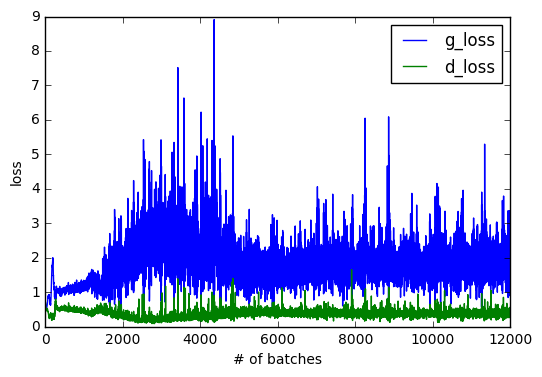

In [127]:
plot_history('dcgan_mnist1/g_loss_history.log', 'dcgan_mnist1/d_loss_history.log')

- g_lossとd_lossは競合関係にある
- つりあっている方がよく、どちらかが急に下がったりすると危険な兆候
- generatorが負けてg_lossが上がるケースが多い？
- g_lossは上がる傾向にあるがしばらく様子見していたほうがよいケースもある

## Generatorが生成した画像を描画

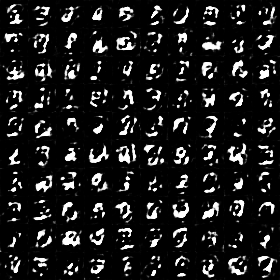

In [121]:
from IPython.display import Image
Image('dcgan_mnist1/epoch-001.png')

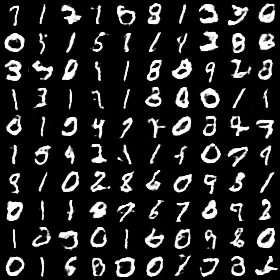

In [122]:
Image('dcgan_mnist1/epoch-019.png')

## モデル改善

論文で提案されているDCGANの改善を導入していく

### SGDの代わりにAdamを使う

In [137]:
def train(batch_size):
    # load MNIST data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_on_generator = generator_containing_discriminator(generator, discriminator)
    
    d_optim = Adam(lr=0.001, beta_1=0.9)
    g_optim = Adam(lr=0.001, beta_1=0.9)
    
    # generator: trainable, discriminator: freeze
    discriminator_on_generator.compile(loss='binary_crossentropy', optimizer=g_optim)

    # discriminator: trainable
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)

    d_loss_history = []
    g_loss_history = []

    for epoch in range(20):
        print('epoch:', epoch)
        num_batches = int(X_train.shape[0] / batch_size)
        print('number of batches', num_batches)
        for index in range(num_batches):
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(batch_size)])
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            generated_images = generator.predict(noise, verbose=0)

            # train discriminator
            X = np.concatenate((image_batch, generated_images))
            y = [1] * batch_size + [0] * batch_size
            d_loss = discriminator.train_on_batch(X, y)
            d_loss_history.append(d_loss)

            # train generator
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(batch_size)])
            g_loss = discriminator_on_generator.train_on_batch(noise, [1] * batch_size)
            g_loss_history.append(g_loss)

            print('epoch: %d, batch: %d, g_loss: %f, d_loss: %f' % (epoch, index, g_loss, d_loss))

        image = combine_images(generated_images)
        image = image * 127.5 + 127.5
        Image.fromarray(image.astype(np.uint8)).save('epoch-%03d.png' % epoch)

        # save training history
        with open('g_loss_history.log', 'w') as fp:
            for x in g_loss_history:
                fp.write('%f\n' % x)

        with open('d_loss_history.log', 'w') as fp:
            for x in d_loss_history:
                fp.write('%f\n' % x)

- Adamのデフォルト設定を使用